In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [6]:
# Load datasets
customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')


In [7]:
# Merge datasets to create a unified view
transactions_products = pd.merge(transactions, products, on="ProductID", how="left")
customer_data = pd.merge(transactions_products, customers, on="CustomerID", how="left")

In [8]:
# Aggregate data to create customer profiles
customer_profiles = customer_data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    total_quantity=("Quantity", "sum"),
    unique_products=("ProductID", "nunique"),
    favorite_category=("Category", lambda x: x.mode()[0] if not x.mode().empty else None),
    region=("Region", "first")
).reset_index()

In [10]:
# Prepare data for vectorization
encoder = OneHotEncoder(sparse_output=False)
encoded_categories = encoder.fit_transform(customer_profiles[["favorite_category", "region"]])

In [11]:
# Create numerical feature vectors
feature_vectors = np.hstack((
    customer_profiles[["total_spent", "total_quantity", "unique_products"]].values,
    encoded_categories
))


In [12]:
# Compute cosine similarity between all customers
similarity_matrix = cosine_similarity(feature_vectors)

In [13]:
# Extract similarity for the first 20 customers (C0001–C0020)
customer_ids = customer_profiles["CustomerID"].tolist()
top_20_ids = customer_ids[:20]

In [14]:
# Generate recommendations for the first 20 customers
recommendations = {}
for idx, cust_id in enumerate(top_20_ids):
    # Get similarity scores and sort
    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    # Exclude the customer themselves and pick top 3
    top_3 = [(customer_ids[i], score) for i, score in scores[1:4]]
    recommendations[cust_id] = top_3

In [15]:
# Convert recommendations into the specified Lookalike.csv format
lookalike_data = []
for cust_id, recs in recommendations.items():
    lookalike_data.append({
        "cust_id": cust_id,
        "lookalikes": [{"cust_id": rec[0], "score": rec[1]} for rec in recs]
    })


In [16]:
lookalike_df = pd.DataFrame(lookalike_data)

In [17]:
# Save Lookalike.csv
lookalike_df.to_csv('Lookalike.csv', index=False)

In [18]:
print("Lookalike.csv has been generated.")

Lookalike.csv has been generated.


In [19]:
# Test for a specific customer (e.g., C0001)
customer_id = "C0001"

# Find the recommendations for this customer
recommendations = lookalike_df[lookalike_df['cust_id'] == customer_id]['lookalikes'].iloc[0]
print(f"Recommendations for {customer_id}: {recommendations}")

Recommendations for C0001: [{'cust_id': 'C0120', 'score': 0.9999999483213668}, {'cust_id': 'C0068', 'score': 0.9999999151253842}, {'cust_id': 'C0102', 'score': 0.9999999091775381}]


In [20]:
# Check similarity scores for C0001 and its lookalikes
idx = customer_ids.index("C0001")
similarities = similarity_matrix[idx]
sorted_scores = sorted(list(enumerate(similarities)), key=lambda x: x[1], reverse=True)

# Display top similar customers
for i, score in sorted_scores[:5]:
    print(f"CustomerID: {customer_ids[i]}, Similarity Score: {score}")

CustomerID: C0001, Similarity Score: 1.0000000000000002
CustomerID: C0120, Similarity Score: 0.9999999483213668
CustomerID: C0068, Similarity Score: 0.9999999151253842
CustomerID: C0102, Similarity Score: 0.9999999091775381
CustomerID: C0184, Similarity Score: 0.9999999051552908


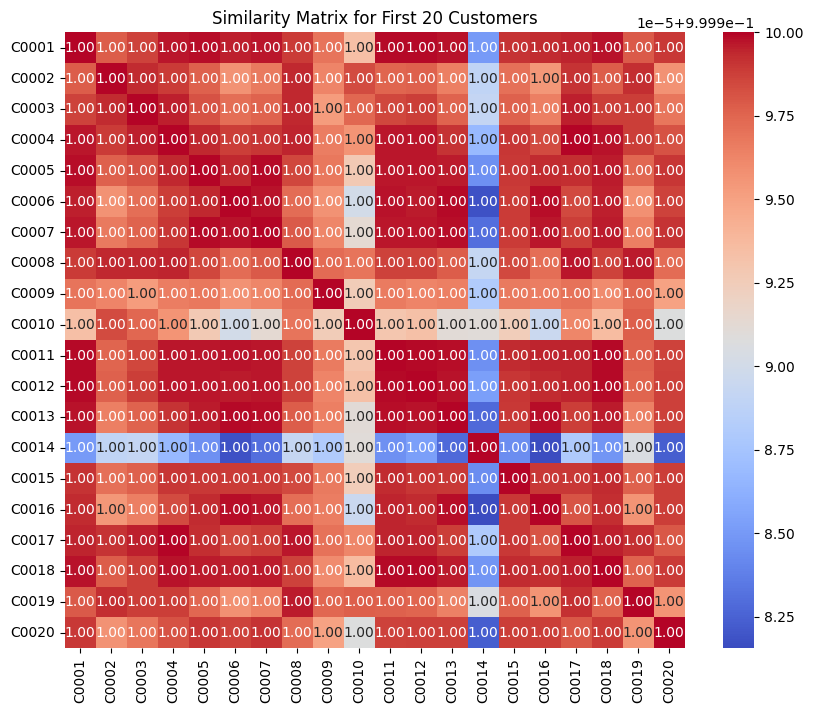

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot similarity matrix for the first 20 customers
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:20, :20], annot=True, fmt=".2f", cmap="coolwarm", xticklabels=top_20_ids, yticklabels=top_20_ids)
plt.title("Similarity Matrix for First 20 Customers")
plt.show()